# **Reinforcement Learning Project - BlackJack**


### In this project, we will try to identify the most effective game strategy for Blackjack through reinforcement learning. You will have the opportunity to investigate the fundamentals of Reinforcement Learning and explore various approaches.

## Objectives

Key aspects of this project

*   OpenAI Gym Environment Selection
*   Reinforcement Learning Concept Explanation
*   Blackjack Environment Training and Testing
*   Environment Setup
*   Learning Techniques
*   Experiment Logging
*   Comparisons and Analyses

----


## __Table of Contents__
<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li><a href="#Setup">Import Libraries and Setup</a>
    <li><a href="#Setup">Blackjack Environment</a>
    <li><a href="#Setup">Models</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Random</a></li>
            <li><a href="#Importing-Required-Libraries">Monte Carlo Base Method</a></li>
            <li><a href="#Importing-Required-Libraries">Monte Carlo on Policy with Exploring Starts </a></li>
            <li><a href="#Defining-Helper-Functions">QLearning</a></li>
             <li><a href="#Defining-Helper-Functions">Sarsa (Temporal Difference control)</a></li>
        </ol>
    </li>
</ol>


## 1. Objectives


### Define the objectives

## 2. Import Libraries and Setup 

### Importing Required Libraries

_We recommend you import all required libraries in one place (here):_


In [1]:
# !pip install gym==0.22.0 pygame

import gym
import matplotlib.pyplot as plt
import random
import itertools
import time
import torch
from tabulate import tabulate
from collections import namedtuple, deque

import sys
sys.path.append('..') 

from src.features.blackjackutility import game_result, average_wins, games_with_policy
from src.visualization.visualize import plot_value_function, plot_policy_blackjack, training_results, create_grids, create_plots
from src.models.MonteCarlo import monte_carlo_ES
from src.models.MonteCarloBase import monte_carlo
from src.models.QLearning_class import QLearningAgent
from src.models.Sarsa_class import SarsaAgent

## 3. Blackjack Environment

We create an openAI gym blackjack enviroment by calling gym method through the use of Make function.


In [2]:
environment = gym.make("Blackjack-v1", sab = True)

Now, it's time to explore the observation space in our environment. The observation space represents the set of all conceivable states, and we can access this space using the observation_space method

In [3]:
print(environment.observation_space)
print(environment.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


This can be described as:

States -> Tuple(Discrete(32), Discrete(11), Discrete(2)) where:
* The player's card sum can range from the lowest (1) to the highest (11, 10, 11), resulting in 32 possible states.
* The dealer's face-up card can take values between 1 and 11.
* The 'usable Ace' space can be either True or False, equating to 2 possible states.

    Hence, there are a total of 704 possible states, computed as: $32 \times 11 \times 2 = 704$. 

Actions -> [0,1]
* Either stand or hit: [0,1] i.e 0 for stand , 1 for hit


In [4]:
state = environment.reset()
print("s_{} = {}".format(0, environment.observation_space.sample())) 

s_0 = (27, 8, 0)


Let's see more possible states:


In [5]:
for i in range(15):
    print("s_{} = {}".format(i, environment.observation_space.sample()))

s_0 = (30, 1, 1)
s_1 = (7, 4, 0)
s_2 = (11, 9, 0)
s_3 = (28, 5, 1)
s_4 = (31, 0, 0)
s_5 = (20, 9, 0)
s_6 = (25, 0, 1)
s_7 = (8, 1, 0)
s_8 = (21, 10, 0)
s_9 = (14, 8, 0)
s_10 = (7, 4, 1)
s_11 = (18, 10, 0)
s_12 = (26, 4, 0)
s_13 = (12, 3, 0)
s_14 = (19, 3, 0)


In [6]:
for t in range(10):
    action=environment.action_space.sample()
    if action:
        print("Hit, A_{} = {}".format(t,action))
    else:
        print("Stay",action)

Stay 0
Hit, A_1 = 1
Stay 0
Stay 0
Stay 0
Hit, A_5 = 1
Hit, A_6 = 1
Stay 0
Hit, A_8 = 1
Stay 0


Let's also check the player and dealers cards by using `environment.player` and `environment.dealer` function 


In [7]:
print(environment.observation_space.sample())
print(environment.player)
print(environment.dealer)

(22, 6, 0)
[10, 1]
[10, 1]


We will introduce a bit more terminology, **Episode** is a set of  agent-environment interactions from initial to final state, i.e it's one game that agent the plays. In addition, our agents are operating in a discrete-time game. Each time-advancing decision is a **step** (e.x. taking some action from some state). It's easy to see that each Episode consists of a series of steps. 

Let's play through some episodes of the game, choosing random actions for each step: 


In [8]:
episodes = 2
sum_ = 0
result = 0
error = 0

#setting the seed for reproduceability

for episode in range(episodes):
    state = environment.reset()
    done = False
    print("_________________________________________")
    print("Episode {}".format(episode))
   

    print("State: {}".format(state))
    print("The Agent's current sum: {}, The Dealer's one showing card: {}, Agent's usable ace: {}".format(state[0],state[1],state[2]))
    print("The Agent has the following cards: {}".format(environment.player))
    print('The Dealer has the following cards: {}'.format(environment.dealer))
    while not done:
    
        action = environment.action_space.sample()
       
        if action:
            print("Hit")
            
        else:
            print("Stand")

        state, reward, done, info = environment.step(action)

        print("State: {}".format(state))
        print("The Agent's current sum: {}, The Dealer's one showing card: {}, Agent's usable ace: {}".format(state[0],state[1],state[2]))
        print("The Agent has the following cards: {}".format(environment.player))
        print('The Dealer has the following cards: {}'.format(environment.dealer))

    print("Done: {}".format(done))
    result = game_result(environment,state)
    sum_ += reward
sum_

_________________________________________
Episode 0
State: (13, 10, False)
The Agent's current sum: 13, The Dealer's one showing card: 10, Agent's usable ace: False
The Agent has the following cards: [3, 10]
The Dealer has the following cards: [10, 10]
Stand
State: (13, 10, False)
The Agent's current sum: 13, The Dealer's one showing card: 10, Agent's usable ace: False
The Agent has the following cards: [3, 10]
The Dealer has the following cards: [10, 10]
Done: True
state: (13, 10, False)
player has [3, 10]
the players current sum:13,dealer's one showing card:10, usable ace:False
dealer cards: [10, 10] and score: 20 your score i: 13 
agent  loses
_________________________________________
Episode 1
State: (18, 3, False)
The Agent's current sum: 18, The Dealer's one showing card: 3, Agent's usable ace: False
The Agent has the following cards: [8, 10]
The Dealer has the following cards: [3, 8]
Stand
State: (18, 3, False)
The Agent's current sum: 18, The Dealer's one showing card: 3, Agent

-2.0

Run the code above a few more times and observe that our games are not really lucky. Try playing yourself, may be you can do better than a random action generator:


In [9]:
episodes = 10
sum_ = 0
result = 0
error = 0

#setting the seed for reproduceability

for episode in range(episodes):
    state = environment.reset()
    done = False
    print("_________________________________________")
    print("Episode {}".format(episode))
   

    print("State: {}".format(state))
    print("The Agent's current sum: {}, The Dealer's one showing card: {}, Agent's usable ace: {}".format(state[0],state[1],state[2]))
    print("The Agent has the following cards: {}".format(environment.player))
    print('The Dealer has the following cards: {}'.format(environment.dealer))
    while not done:
    
        action = environment.action_space.sample()
       
        if action:
            print("Hit")
            
        else:
            print("Stand")

        state, reward, done, info = environment.step(action)

        print("State: {}".format(state))
        print("The Agent's current sum: {}, The Dealer's one showing card: {}, Agent's usable ace: {}".format(state[0],state[1],state[2]))
        print("The Agent has the following cards: {}".format(environment.player))
        print('The Dealer has the following cards: {}'.format(environment.dealer))

    print("Done: {}".format(done))
    result = game_result(environment,state)
    sum_ += reward
sum_

_________________________________________
Episode 0
State: (10, 10, False)
The Agent's current sum: 10, The Dealer's one showing card: 10, Agent's usable ace: False
The Agent has the following cards: [5, 5]
The Dealer has the following cards: [10, 9]
Hit
State: (21, 10, True)
The Agent's current sum: 21, The Dealer's one showing card: 10, Agent's usable ace: True
The Agent has the following cards: [5, 5, 1]
The Dealer has the following cards: [10, 9]
Stand
State: (21, 10, True)
The Agent's current sum: 21, The Dealer's one showing card: 10, Agent's usable ace: True
The Agent has the following cards: [5, 5, 1]
The Dealer has the following cards: [10, 9]
Done: True
state: (21, 10, True)
player has [5, 5, 1]
the players current sum:21,dealer's one showing card:10, usable ace:True
dealer cards: [10, 9] and score: 19 your score i: 21 
agent  wins
_________________________________________
Episode 1
State: (7, 10, False)
The Agent's current sum: 7, The Dealer's one showing card: 10, Agent's u

-4.0

At first we will start by exploring what greedy policy is and does:


### Epsilon-Greedy Policy

If you remember, as was mentioned before, policy is just a function that defines which action our agent should take based on the current state. In our environment, a simple deterministic policy $\pi$ for the the state $(15,10,0)$ may look like: 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0EP1EN/Screenshot%202022-11-23%20at%2010.36.45%20AM.png" width="50%" alt="iris image">


You may ask why wouldn't we always use the best action, the action with the best estimated reward, what's the point of this epsilon constant. For it we will have to learn about 2 more concepts: 
 
* **Exploration** happens when the agent takes the random action to explore more opportunities, gather more information about possible actions and the environment.
* **Exploitation** happens when the agent makes the best decision given current information, it uses the best estimated action to maximize the reward. 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0EP1EN/Screenshot%202022-11-23%20at%2010.51.11%20AM.png" width="50%" alt="iris image">

As demonstrated in the diagram above, **Epsilon** defines the trade-off between Exploration and Exploitation.  We need it because the best long-term strategy may involve short-term sacrifices and in most cases, agents must explore the environment and gather enough information to make the best overall decisions. It may save our agent from doing decisions that work instead of finding the best actions. 

Let's define a new python function that will follow the epsilon probability and return an action:


## 4. Models

### 4.1 Random

In [36]:
def random_action(action_space):
    return action_space.sample()

random_policy = random_action(environment.action_space)

average, std_win = average_wins(environment, episodes=200000)
print("Average wins:", average, std_win)

Average wins: 0.28349 0.0010077782987840133


### 4.2 Monte Carlo Method

#### 4.2.1 Monte Carlo Base

In [5]:
V, DELTA = monte_carlo(environment, N_episodes = 200000, discount_factor=1, epsilon = 0.1, theta=0)  

In [4]:
average, std_win = average_wins(environment, episodes=200000)
print("Average number of wins", average)

Average number of wins 0.282025


#### 4.2.1 Monte Carlo with First Starts
This concept is an important strategic decision that you have to make every time you build an episode based learning algorithm. Note that every episode, we update our Q function, based on states and actions that were visited, some state-action pairs can be visited more than one per episode. **Every-Visit MC** is Monte Carlo algorithm that averages returns for every time state-action pair is visited in an episode, where **First-visit MC** averages returns only for first time state-action pair is visited in an episode.


#### 4.2.2 Monte Carlo with Exploring-Starts
Note that in big and complicated environments not every (state,action) pair may be visited during the learning process. One possible solution to this problem may be adding **exploring-starts** method. In the beginning of each episode we are always starting in the initial state $S$, but with exploring-starts we will choose our starting state randomly. **Exploring-starts** is specifying that episodes start in a state–action pair, and that every pair has a nonzero probability of being selected as the start.

In [12]:
policy, V, Q, DELTA = monte_carlo_ES(environment, N_episodes = 200000, discount_factor = 1, epsilon = 0.1, first_visit = True, theta=0)  

Let's plot the delta value for each episode to see how the update rates are changing:


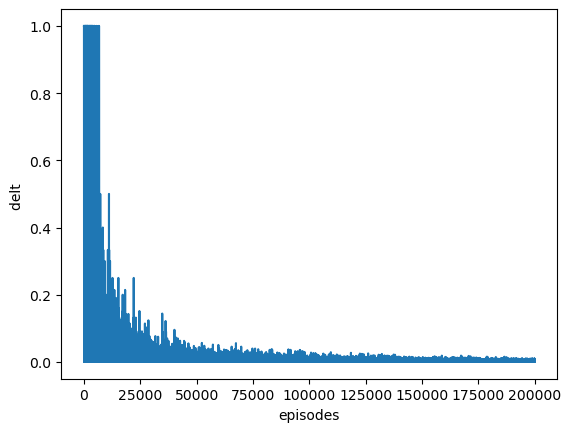

In [13]:
plt.plot(DELTA)
plt.xlabel("episodes")
plt.ylabel("delt ")
plt.show()

As you can see the delta parameter is generally decreasing, which makes sense since our model comes closer and closer to the optimal values for the value function. Speaking of which, let's see the map of expected returns based on what player has and what the dealer has. 


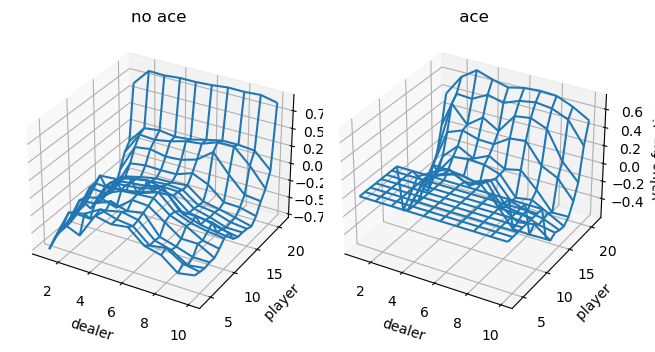

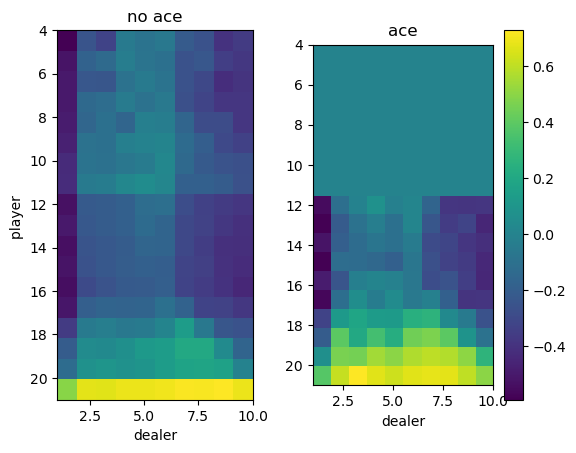

In [14]:
plot_value_function(V)

We see a general trend, as the score of the player increases the value function takes on higher values so our expected return grows. Let see the average result of playing ten thousand games. Let's compare the result, first  using the random policy.


In [15]:
average, std_win = average_wins(environment, episodes=200000)
print("Average number of wins", average)

Average number of wins 0.28193


So the random policy gives us around $28\%$ of wins, now let's see what the trained policy returns:


In [16]:
average, std_win = average_wins(environment, policy, episodes=200000)
print("Average wins:", average, std_win)

Average wins: 0.432485 0.0011077944862992416


Oh wow, more than 10% increase, that's not bad at all, lets see what happens when we use more episodes to train our model. 


In [17]:
policy, V, Q, DELTA = monte_carlo_ES(environment, N_episodes = 500000, discount_factor = 1, first_visit = True, theta = 0)  

Let's see what's happening with the learning rate:


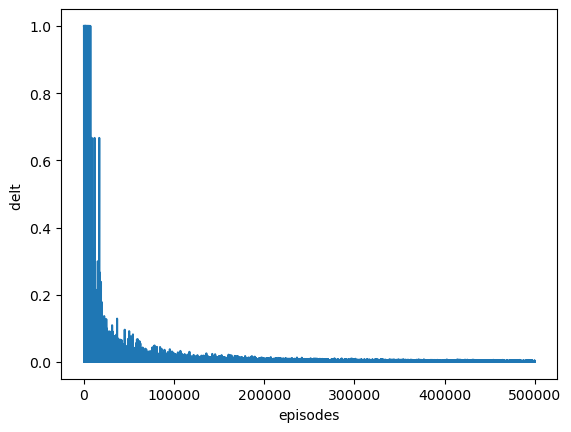

In [18]:
plt.plot(DELTA)
plt.xlabel("episodes")
plt.ylabel("delt ")
plt.show()

Falling as expected, now let's check what our policy returns:


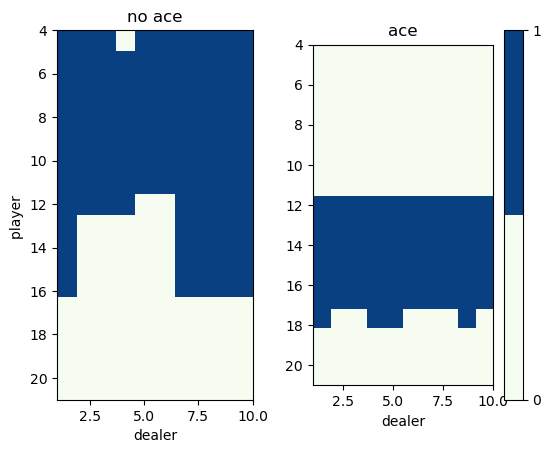

In [19]:
plot_policy_blackjack(policy)

It looks like the optimal policy for blackjack is: If the agent has no ace, the higher the dealer is showing, the more likely the agent is to hit, the exception is if the dealer has an ace. If the agent has an ace, the strategy is different. The agent will stick if the sum of their cards is over 11 and, for the most part, hold the player's sum is over 18. Let's plot the value function to explore the expected returns after 50 000 episodes:


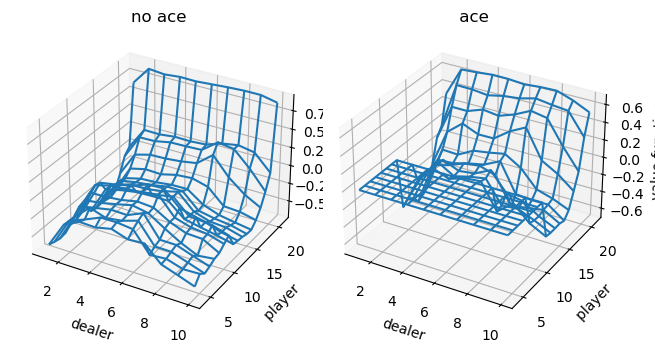

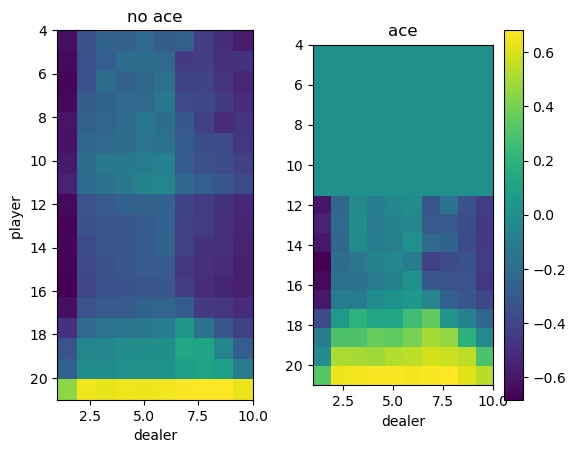

In [20]:
plot_value_function(V)

And, most importantly, lets compare the accuracy of the results:


In [21]:
average, std_win = average_wins(environment, policy, episodes = 500000)
print("Average wins:", average, std_win)

Average wins: 0.432016 0.0007005400427441675


We see as the accuracy is now approximately 43% a 15 % improvement from a random policy:


In [24]:
accuracy = [] 
episodes = []

for n_episode in [1, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 2000000]:
#for n_episode in [100002000000]:
   
    print("n_episode: ", str(n_episode))
    policy, V, Q, DELTA = monte_carlo_ES(environment = environment, 
                                         N_episodes = n_episode, 
                                         discount_factor = 1, 
                                         first_visit = True, 
                                         theta = 0)  
    
    average ,std_win = average_wins(environment = environment, 
                                    policy = policy, 
                                    episodes = 5000000)
    
    print("n_episode: ", str(n_episode), " average: ", str(average))
    accuracy.append(average)
    episodes.append(n_episode)

n_episode:  1
n_episode:  1  average:  0.2810658
n_episode:  500
n_episode:  500  average:  0.3548102
n_episode:  1000
n_episode:  1000  average:  0.3962594
n_episode:  5000
n_episode:  5000  average:  0.4156284
n_episode:  10000
n_episode:  10000  average:  0.4232948
n_episode:  50000
n_episode:  50000  average:  0.4290036
n_episode:  100000
n_episode:  100000  average:  0.4318436
n_episode:  500000
n_episode:  500000  average:  0.4321444
n_episode:  1000000
n_episode:  1000000  average:  0.4324248
n_episode:  2000000
n_episode:  2000000  average:  0.4320546


We see that after 50000 episodes the improvement is negligible.


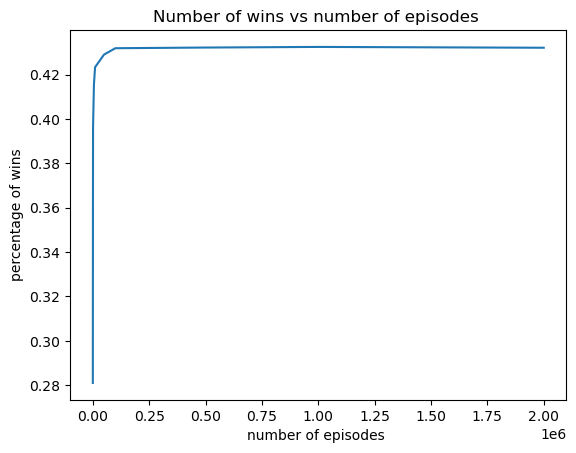

In [25]:
plt.plot(episodes, accuracy)
plt.title("Number of wins vs number of episodes ")
plt.ylabel('percentage of wins')
plt.xlabel('number of episodes ')
plt.show()

In [7]:
# Define the hyperparameter values to test
n_episode_values = [200000]
discount_factor_values = [0.7, 0.9, 0.95, 0.99, 1.0]
first_visit_values = [True, False]
epsilon_values = [0.05, 0.1, 0.2, 0.5, 0.9]
theta_values = [0]  # You can add more values if needed

# Lists to store the results
tuning_results = []

# Perform grid search
for n_episode, discount_factor, first_visit, epsilon, theta in itertools.product(n_episode_values, discount_factor_values, first_visit_values, epsilon_values, theta_values):
    print(f"n_episode: {n_episode}, discount_factor: {discount_factor}, first_visit: {first_visit}, epsilon: {epsilon}, theta: {theta}")
    
    start_time = time.time()  # Record the start time
    
    policy, V, Q, DELTA = monte_carlo_ES(environment=environment, 
                                         N_episodes=n_episode, 
                                         discount_factor=discount_factor, 
                                         first_visit=first_visit, 
                                         epsilon=epsilon,
                                         theta=theta)
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time

    # Convert elapsed time to minutes with two decimal places
    elapsed_time_minutes = round(elapsed_time / 60, 2)
    
    average, std_win = average_wins(environment=environment, policy=policy, episodes=5000000)
    
    print(f"Average: {average}")
    print(f"Elapsed Time: {elapsed_time_minutes:.2f} minutes\n")

    tuning_results.append({
        "n_episode": n_episode,
        "discount_factor": discount_factor,
        "first_visit": first_visit,
        "epsilon": epsilon,
        "theta": theta,
        "average": average,
        "elapsed_time": elapsed_time_minutes
    })

# Find the best combination of hyperparameters
best_result = max(tuning_results, key=lambda x: x["average"])
print("Best Hyperparameters:")
print("n_episode:", best_result["n_episode"])
print("discount_factor:", best_result["discount_factor"])
print("first_visit:", best_result["first_visit"])
print("epsilon:", best_result["epsilon"])
print("theta:", best_result["theta"])
print("Average:", best_result["average"])
print("Elapsed Time:", best_result["elapsed_time"], "minutes")

# Create a table of results
headers = ["n_episode", "discount_factor", "first_visit", "epsilon", "theta", "average", "elapsed_time (min)"]
table = [list(result.values()) for result in tuning_results]
print(tabulate(table, headers, tablefmt="grid"))


n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.05, theta: 0
Average: 0.4337316
Elapsed Time: 1.19 minutes

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.1, theta: 0
Average: 0.4337862
Elapsed Time: 1.65 minutes

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.2, theta: 0
Average: 0.4336478
Elapsed Time: 1.97 minutes

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.5, theta: 0
Average: 0.4330446
Elapsed Time: 1.37 minutes

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.9, theta: 0
Average: 0.43286
Elapsed Time: 1.46 minutes

n_episode: 200000, discount_factor: 0.7, first_visit: False, epsilon: 0.05, theta: 0
Average: 0.4322118
Elapsed Time: 1.25 minutes

n_episode: 200000, discount_factor: 0.7, first_visit: False, epsilon: 0.1, theta: 0
Average: 0.4322836
Elapsed Time: 2.34 minutes

n_episode: 200000, discount_factor: 0.7, first_visit: False, epsilon: 0.2, theta: 0
Aver

In [7]:
import itertools
import time

# Define the hyperparameter values to test
n_episode_values = [200000]
discount_factor_values = [0.7, 0.9, 0.95, 0.99, 1.0]
first_visit_values = [True, False]
epsilon_values = [0.05, 0.1, 0.2, 0.5, 0.9]
theta_values = [0]#, 0.001, 0.05, 0.1, 0.5, 1.0]

# Lists to store the results
tuning_results = []

# Perform grid search
for n_episode, discount_factor, first_visit, epsilon, theta in itertools.product(n_episode_values, discount_factor_values, first_visit_values, epsilon_values, theta_values):
    print(f"n_episode: {n_episode}, discount_factor: {discount_factor}, first_visit: {first_visit}, epsilon: {epsilon}, theta: {theta}")
    
    start_time = time.time()  # Record the start time

    policy, V, Q, DELTA = monte_carlo_ES(environment=environment, 
                                         N_episodes=n_episode, 
                                         discount_factor=discount_factor, 
                                         first_visit=first_visit, 
                                         epsilon=epsilon,
                                         theta=theta)
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time


    average, std_win = average_wins(environment=environment, policy=policy, episodes=5000000)
    
    print(f"Average: {average}\n")
    print(f"Elapsed Time: {elapsed_time} seconds\n")  # Print the elapsed time
    
    tuning_results.append({
        "n_episode": n_episode,
        "discount_factor": discount_factor,
        "first_visit": first_visit,
        "epsilon": epsilon,
        "theta": theta,
        "average": average,
        "elapsed_time": elapsed_time
    })

# Find the best combination of hyperparameters
best_result = max(tuning_results, key=lambda x: x["average"])
print("Best Hyperparameters:")
print("n_episode:", best_result["n_episode"])
print("discount_factor:", best_result["discount_factor"])
print("first_visit:", best_result["first_visit"])
print("epsilon:", best_result["epsilon"])
print("theta:", best_result["theta"])
print("Average:", best_result["average"])
print("Elapsed Time:", best_result["elapsed_time"], "seconds")


n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.05, theta: 0
Average: 0.4324102

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.05, theta: 0.001
Average: 0.3005708

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.05, theta: 0.05
Average: 0.2767416

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.05, theta: 0.1
Average: 0.2916082

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.05, theta: 0.5
Average: 0.3357826

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.05, theta: 1.0
Average: 0.2768974

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.1, theta: 0
Average: 0.4332744

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.1, theta: 0.001
Average: 0.2911614

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.1, theta: 0.05
Average: 0.298341

n_episode: 200000, discount_factor: 0.7, first_v

In Conclusion, we have created a successful algorithm, that was able to give us perhaps not a winning, but an optimal strategy for blackjack. 


In [22]:
games_with_policy(environment = environment, 
                  policy = policy, 
                  episodes = 100)

_________________________________________
Episode 0
State: (18, 3, False)
The Agent's current sum: 18, The Dealer's one showing card: 3, Agent's usable ace: False
The Agent has the following cards: [8, 10]
The Dealer has the following cards: [3, 7]
Stand
State: (18, 3, False)
The Agent's current sum: 18, The Dealer's one showing card: 3, Agent's usable ace: False
The Agent has the following cards: [8, 10]
The Dealer has the following cards: [3, 7, 2, 5]
Done: True
state: (18, 3, False)
player has [8, 10]
the players current sum:18,dealer's one showing card:3, usable ace:False
dealer cards: [3, 7, 2, 5] and score: 17 your score i: 18 
agent  wins
_________________________________________
Episode 1
State: (17, 5, False)
The Agent's current sum: 17, The Dealer's one showing card: 5, Agent's usable ace: False
The Agent has the following cards: [10, 7]
The Dealer has the following cards: [5, 10]
Stand
State: (17, 5, False)
The Agent's current sum: 17, The Dealer's one showing card: 5, Agent

#### 4.2.3 Monte Carlo On Policy

### 4.3 Q-Learning

In [14]:
# hyperparameters
learning_rate = 0.0001
n_episodes = 20000000
start_epsilon = 0.5
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.05

QLearningAgent = QLearningAgent(environment = environment, 
                                learning_rate = learning_rate, 
                                initial_epsilon = start_epsilon, 
                                epsilon_decay = epsilon_decay, 
                                final_epsilon = final_epsilon)

In [15]:
env = gym.wrappers.RecordEpisodeStatistics(environment, deque_size = n_episodes)

QLearningAgent.train(env = env, n_episodes = n_episodes)

100%|██████████| 20000000/20000000 [17:07<00:00, 19462.36it/s]


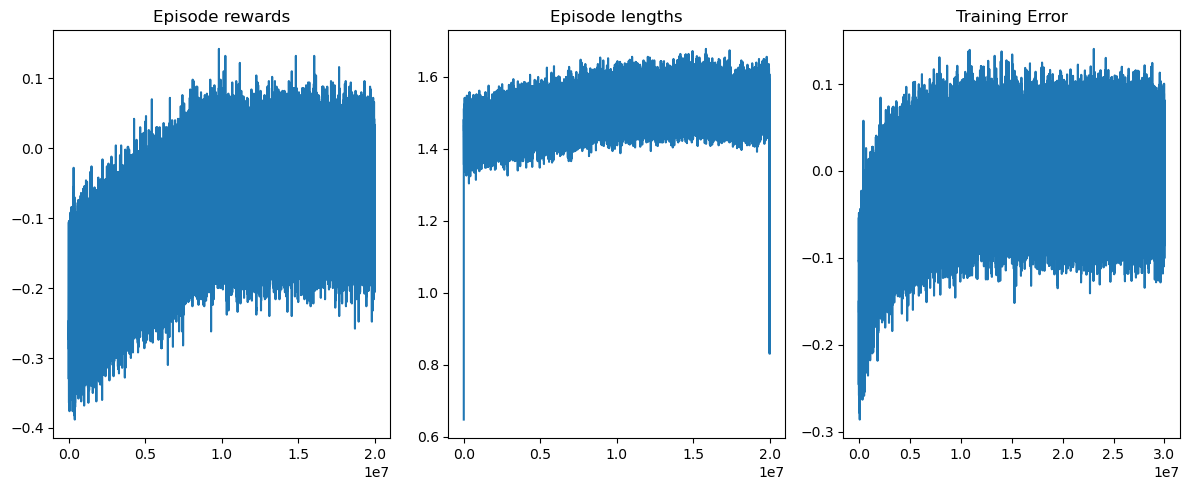

In [16]:
training_results(QLearningAgent, env)

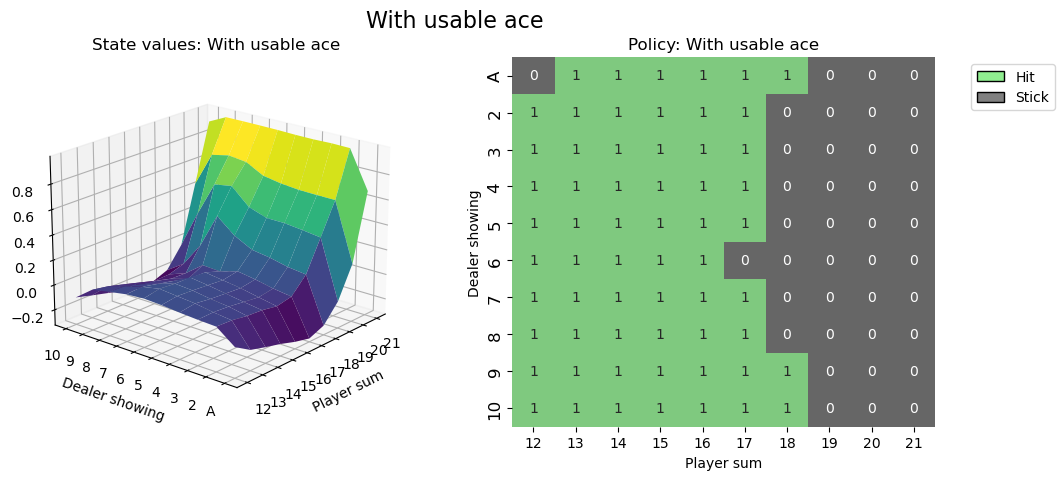

In [17]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(QLearningAgent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

### 4.4 Sarsa (Temporal Difference control)

In [10]:
# hyperparameters
learning_rate = 0.0001
n_episodes = 20000000
start_epsilon = 0.5
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.05

SarsaAgent = SarsaAgent(environment = environment, 
                        learning_rate = learning_rate, 
                        initial_epsilon = start_epsilon, 
                        epsilon_decay = epsilon_decay, 
                        final_epsilon = final_epsilon)

In [11]:
env = gym.wrappers.RecordEpisodeStatistics(environment, deque_size = n_episodes)

SarsaAgent.train(env = env, n_episodes = n_episodes)

  0%|          | 0/20000000 [00:00<?, ?it/s]

100%|██████████| 20000000/20000000 [16:38<00:00, 20033.67it/s]


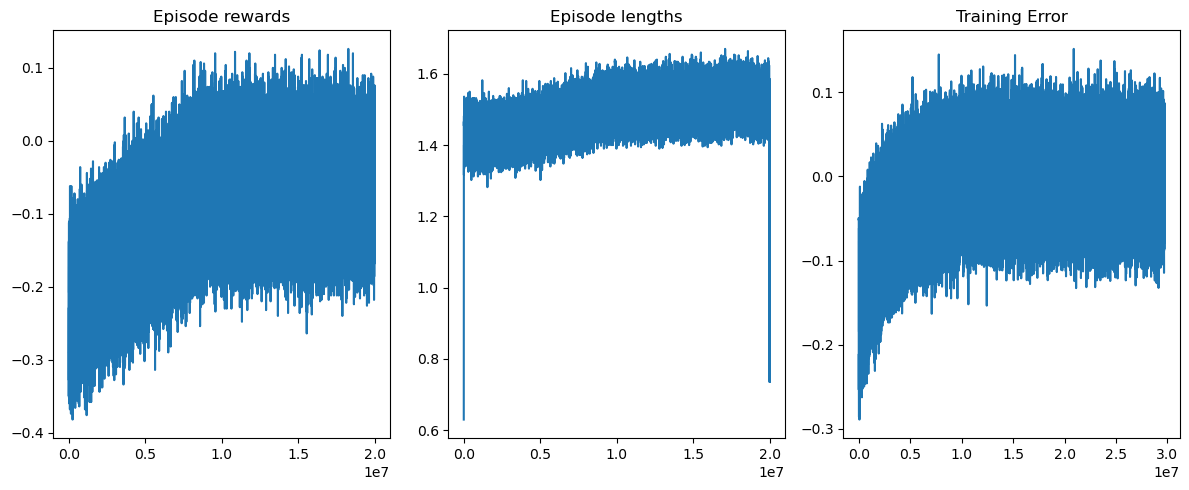

In [12]:
training_results(SarsaAgent, env)

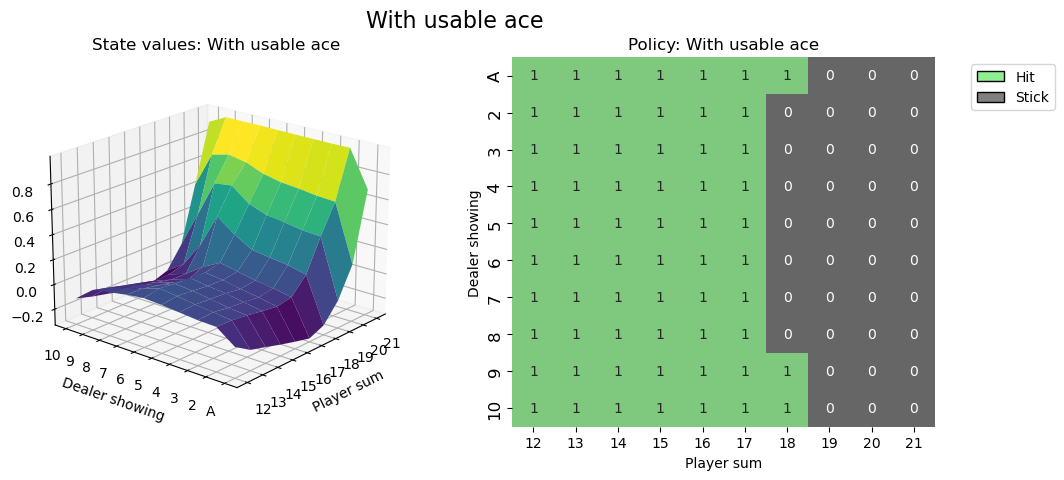

In [13]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(SarsaAgent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

### 4.5 Deep Q-Learning (PyTorch)

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [ ]:
def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

class DeepQLearningAgent(torch.nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DeepQLearningAgent, self).__init__()
        # Fully connected layers
        self.layer_obs_4096 = torch.nn.Linear(n_observations, 4096)
        self.layer_4096_2048 = torch.nn.Linear(4096, 2048)
        self.layer_2048_1024 = torch.nn.Linear(2048, 1024)
        self.layer_1024_act = torch.nn.Linear(1024, n_actions)
        # Activation function
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.leaky_relu = torch.nn.LeakyReLU()
        # Batch normalization
        self.batch_norm4096 = torch.nn.BatchNorm1d(4096)
        self.batch_norm2048 = torch.nn.BatchNorm1d(2048)
        self.batch_norm1024 = torch.nn.BatchNorm1d(1024)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.relu(self.batch_norm4096(self.layer_obs_4096(x)))
        x = self.relu(self.batch_norm2048(self.layer_4096_2048(x)))
        x = self.relu(self.batch_norm1024(self.layer_2048_1024(x)))
        x = self.layer_1024_act(x)

        return x
    

def select_action(state, policy_network, device, eps_start = 0.9, eps_end = 0.05, eps_decay = 1000):
    global steps_done
    sample = random.random()
    eps_threshold = eps_end + (eps_start - eps_end) * torch.exp(-1. * steps_done / eps_decay)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_network(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device = device, dtype = torch.long)
    

def optimize_model(policy_network, target_network, memory, optimizer, device, gamma = 0.9, mini_batch_size = 128):

    if len(memory) < mini_batch_size:
        return
    
    transitions = memory.sample(mini_batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device = device, dtype = torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_network(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(mini_batch_size, device = device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_network(non_final_next_states).max(1)[0]

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_network.parameters(), 100)

    optimizer.step()


def train(policy_network, target_network, memory, optimizer, device, num_episodes = 1000, TAU = 0.01):

    for i_episode in range(num_episodes):
        # Initialize the environment and get it's state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        for t in itertools.count():
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype = torch.float32, device = device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model(policy_network = policy_network, 
                           target_network = target_network, 
                           memory = memory, 
                           optimizer = optimizer, 
                           device = device)

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_network.state_dict()
            policy_net_state_dict = policy_network.state_dict()

            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1-TAU)

            target_network.load_state_dict(target_net_state_dict)

            if done:
                break

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
# Set the device
device = set_device()

policy_net = DeepQLearningAgent(n_observations, n_actions).to(device)
target_net = DeepQLearningAgent(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr = LR, amsgrad = True)
memory = ReplayMemory(10000)

steps_done = 0

In [ ]:
train(policy_network = policy_net, target_network = target_net, memory = memory, optimizer = optimizer, device = device, num_episodes = 10000000, TAU = TAU)